In [2]:
### Reloads modules properly
%load_ext autoreload
%autoreload 2
%load_ext lab_black

# Classifier performance

Lets train a classifier based on `p_T` and whatever other features to predict the z0 of the primary vertex

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import mplhep as hep

In [5]:
hep.style.use("CMS")

In [6]:
!ls -lh /home/raichu/data/data/trk_25k.pkl

-rw-r--r-- 1 raichu raichu 133M Nov  7 15:30 /home/raichu/data/data/trk_25k.pkl


In [7]:
mc = pd.read_pickle("/home/raichu/data/data/mc_25k.pkl")
trk = pd.read_pickle("/home/raichu/data/data/trk_25k.pkl")

## Feature discovery

In [8]:
trk = trk.reset_index()

In [9]:
trk = trk.dropna()

In [10]:
trk = trk.rename(columns={"entry": "event_number", "subentry": "track_number"})

In [11]:
trk.head()

,event_number,track_number,trk_pt,trk_eta,trk_phi,trk_d0,trk_z0,trk_fake
0,0,0,2.623967,1.301414,-0.289234,999.0,-0.878906,2
1,0,1,3.435026,0.566814,-0.159267,999.0,3.339844,2
2,0,2,3.774908,1.815973,-0.240375,999.0,4.921875,1
3,0,3,2.641448,-1.435747,-0.128747,999.0,-0.468750,2
4,0,4,2.320653,1.837421,0.032604,999.0,4.980469,1


In [12]:
trk["is_pv"] = trk["trk_fake"].apply(lambda x: 1 if x == 1 else 0)

Text(1, 0, 'Track $p_T$')

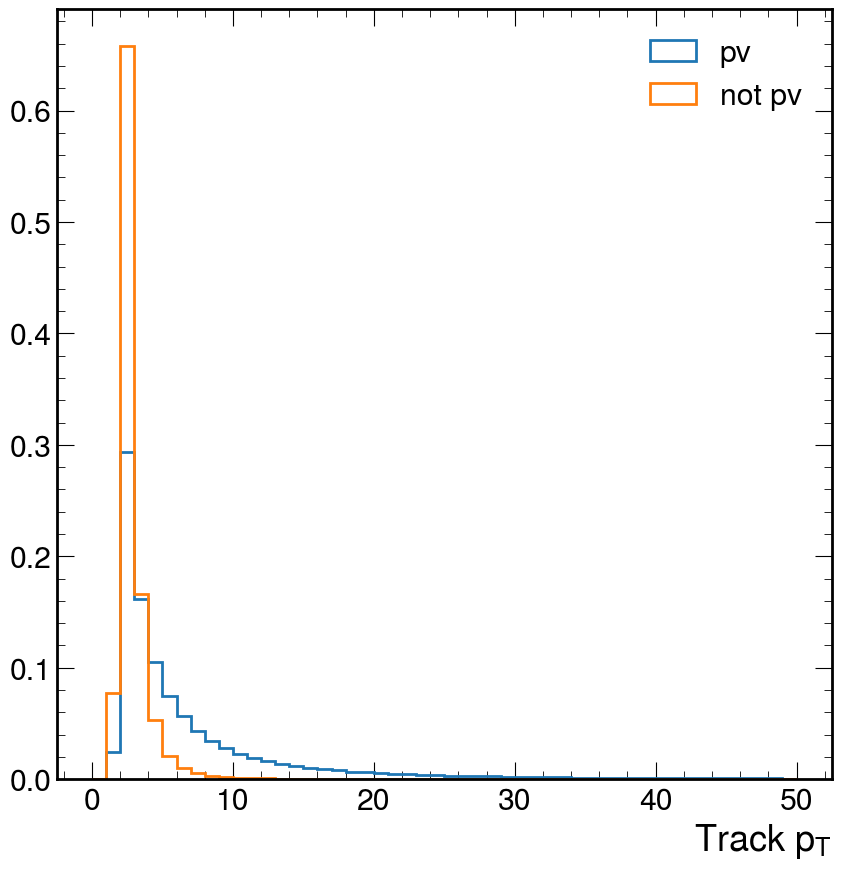

In [13]:
h, be, _ = plt.hist(
    trk.loc[trk["is_pv"] == 1, "trk_pt"].values,
    bins=50,
    range=(0, 50),
    label="pv",
    density=True,
    histtype="step",
    lw=2,
)
_ = plt.hist(
    trk.loc[trk["is_pv"] == 0, "trk_pt"].values,
    bins=be,
    label="not pv",
    density=True,
    histtype="step",
    lw=2,
)
plt.legend()
plt.xlabel("Track $p_T$")

Text(1, 0, 'Track $z_0$')

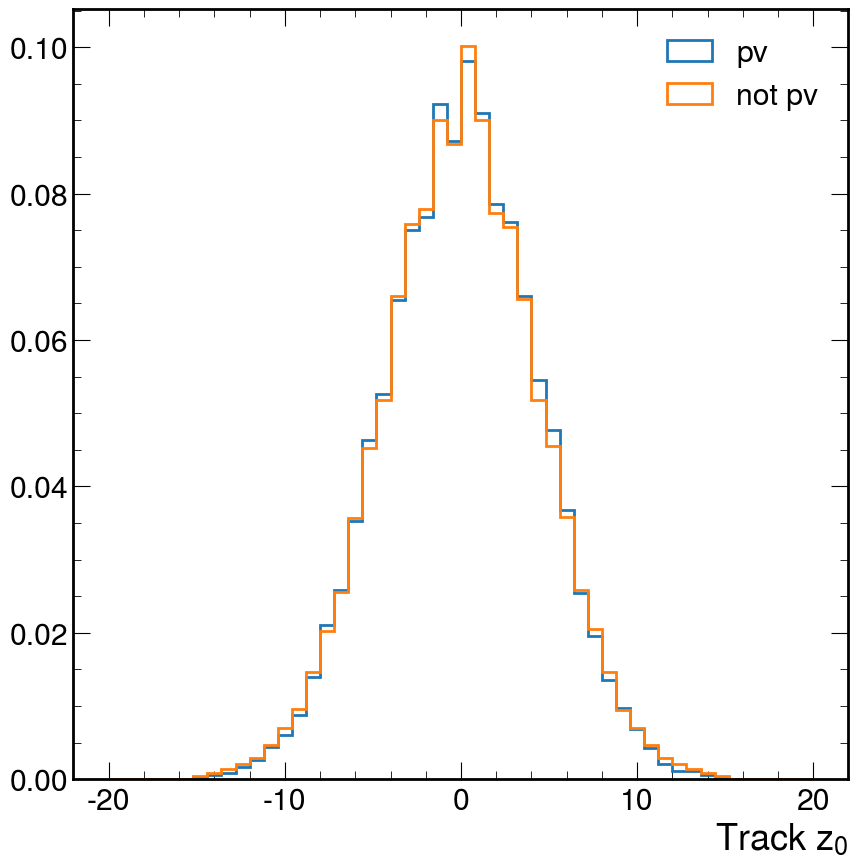

In [14]:
h, be, _ = plt.hist(
    trk.loc[trk["is_pv"] == 1, "trk_z0"].values,
    bins=50,
    range=(-20, 20),
    label="pv",
    density=True,
    histtype="step",
    lw=2,
)
_ = plt.hist(
    trk.loc[trk["is_pv"] == 0, "trk_z0"].values,
    bins=be,
    label="not pv",
    density=True,
    histtype="step",
    lw=2,
)
plt.legend()
plt.xlabel("Track $z_0$")

Text(1, 0, 'Track $\\phi$')

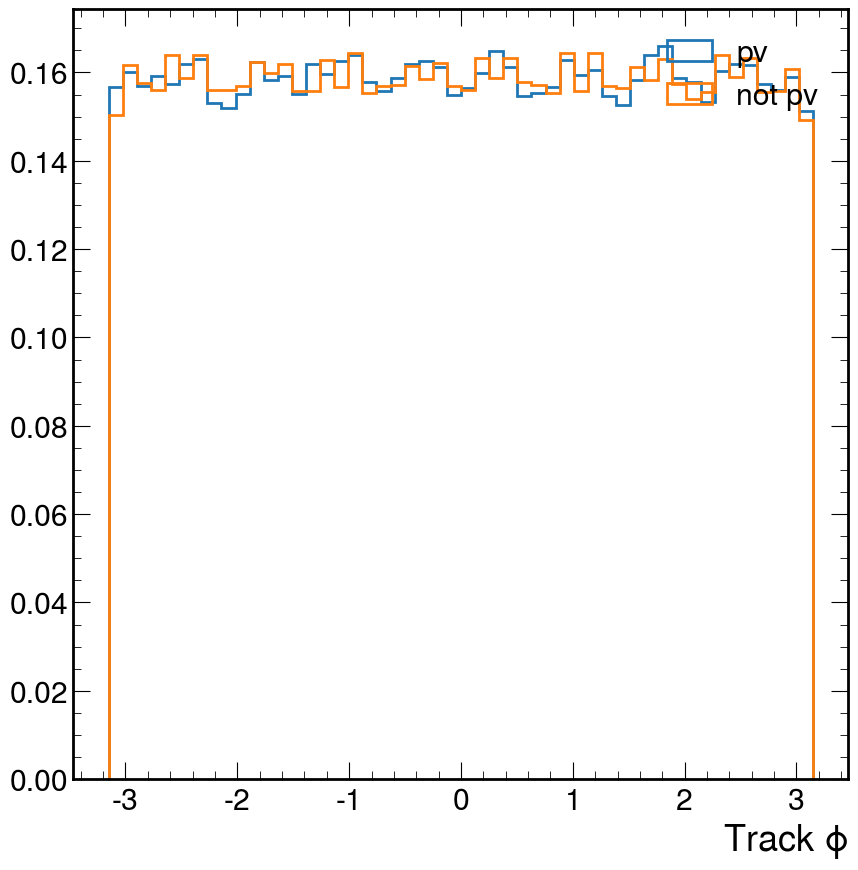

In [15]:
h, be, _ = plt.hist(
    trk.loc[trk["is_pv"] == 1, "trk_phi"].values,
    bins=50,
    range=(-3.15, 3.15),
    label="pv",
    density=True,
    histtype="step",
    lw=2,
)
_ = plt.hist(
    trk.loc[trk["is_pv"] == 0, "trk_phi"].values,
    bins=be,
    label="not pv",
    density=True,
    histtype="step",
    lw=2,
)
plt.legend()
plt.xlabel("Track $\phi$")

Text(1, 0, 'Track $\\eta$')

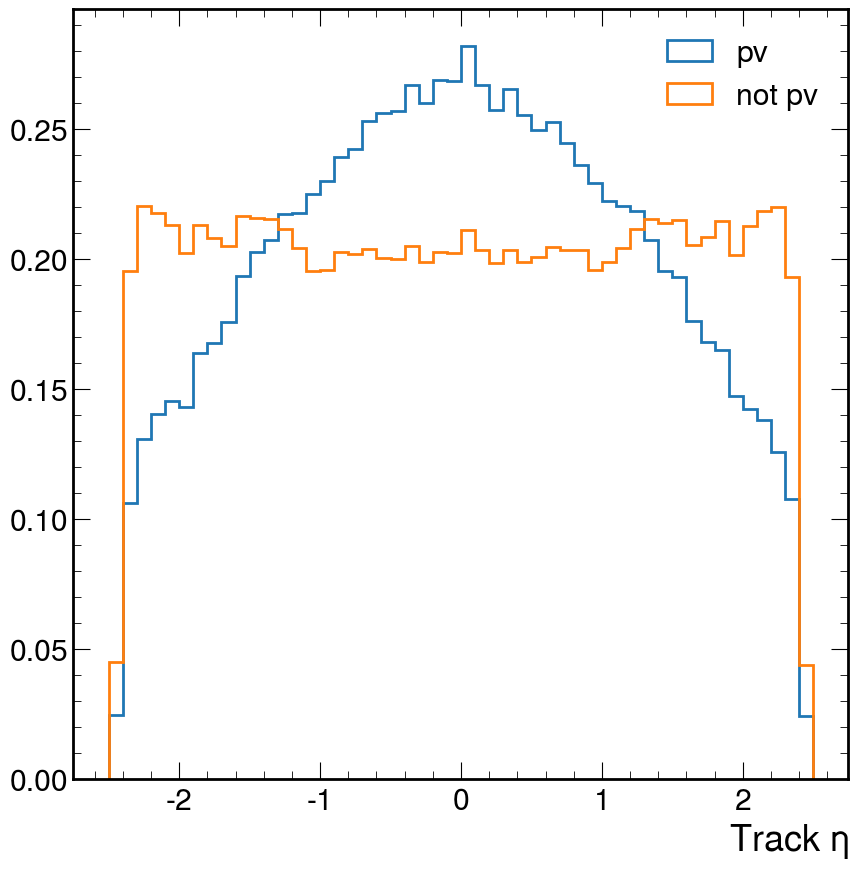

In [16]:
h, be, _ = plt.hist(
    trk.loc[trk["is_pv"] == 1, "trk_eta"].values,
    bins=50,
    range=(-2.5, 2.5),
    label="pv",
    density=True,
    histtype="step",
    lw=2,
)
_ = plt.hist(
    trk.loc[trk["is_pv"] == 0, "trk_eta"].values,
    bins=be,
    label="not pv",
    density=True,
    histtype="step",
    lw=2,
)
plt.legend()
plt.xlabel("Track $\eta$")

## Creating a test and train sets

In [17]:
mc = mc.reset_index()

In [18]:
mc = mc.drop(columns=["subentry"])

In [19]:
mc = mc.rename(columns={"entry": "event_number"})

In [20]:
mc.head()

,event_number,pv_L1reco_z0,pv_L1reco_sum,pv_MC
0,0,5.026911,79.777252,5.055163
1,1,-2.021080,90.041313,-3.608661
2,2,-0.141508,202.421341,-0.261453
3,3,2.744174,303.983124,2.803285
4,4,-1.279072,218.012939,-1.400667


In [21]:
val_df = trk.loc[trk.event_number >= 15000].copy()
val_mc = mc.loc[mc.event_number >= 15000].copy()

In [22]:
idx = np.arange(0, 15000)

In [23]:
np.random.shuffle(idx)

In [24]:
idx_train = idx[0:7500]
idx_test = idx[7500:15000]

In [25]:
train_df = trk.iloc[idx_train].copy()
train_df.head()

,event_number,track_number,trk_pt,trk_eta,trk_phi,trk_d0,trk_z0,trk_fake,is_pv
5179,29,39,2.323081,-0.767960,0.603624,999.0,-2.929688,2,0
10056,55,110,2.615930,-0.915482,-3.102950,999.0,2.050781,2,0
3410,18,142,2.102254,1.301414,-0.884846,999.0,-4.628906,1,1
12220,67,17,2.049097,0.279548,-0.229044,999.0,-1.875000,2,0
9068,50,45,1.954578,1.170690,1.463478,999.0,-1.347656,2,0


In [26]:
test_df = trk.iloc[idx_test].copy()

In [27]:
mc_train = mc.iloc[idx_train].copy()
mc_test = mc.iloc[idx_test].copy()

## logistic regression classifier

In [28]:
wp = train_df.shape[0] / train_df["is_pv"].sum()

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
X_train = train_df["trk_pt"].values
y_train = train_df["is_pv"].values

In [31]:
train_df["weight"] = 1
train_df.loc[train_df.is_pv == 1, "weight"] = wp

In [32]:
weights_train = train_df["weight"].values

In [33]:
clf = LogisticRegression(random_state=0).fit(
    X_train.reshape(-1, 1), y_train, sample_weight=weights_train
)

In [34]:
X_test = test_df["trk_pt"].values
y_test = test_df["is_pv"].values
X_val = val_df["trk_pt"].values
y_val = val_df["is_pv"].values

In [35]:
y_train_pred = clf.predict(X_train.reshape(-1, 1))

In [36]:
y_test_pred = clf.predict(X_test.reshape(-1, 1))
y_val_pred = clf.predict(X_val.reshape(-1, 1))

In [37]:
train_df["y_pred"] = y_train_pred
test_df["y_pred"] = y_test_pred
val_df["y_pred"] = y_val_pred

In [39]:
import pickle

In [40]:
pickle.dump(clf, open("logistic_regression_pt.pkl", "wb"))

## Classification metrics

In [133]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [130]:
cm = confusion_matrix(val_df["is_pv"], val_df["y_pred"], normalize="true")

In [131]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not pv", "pv"])

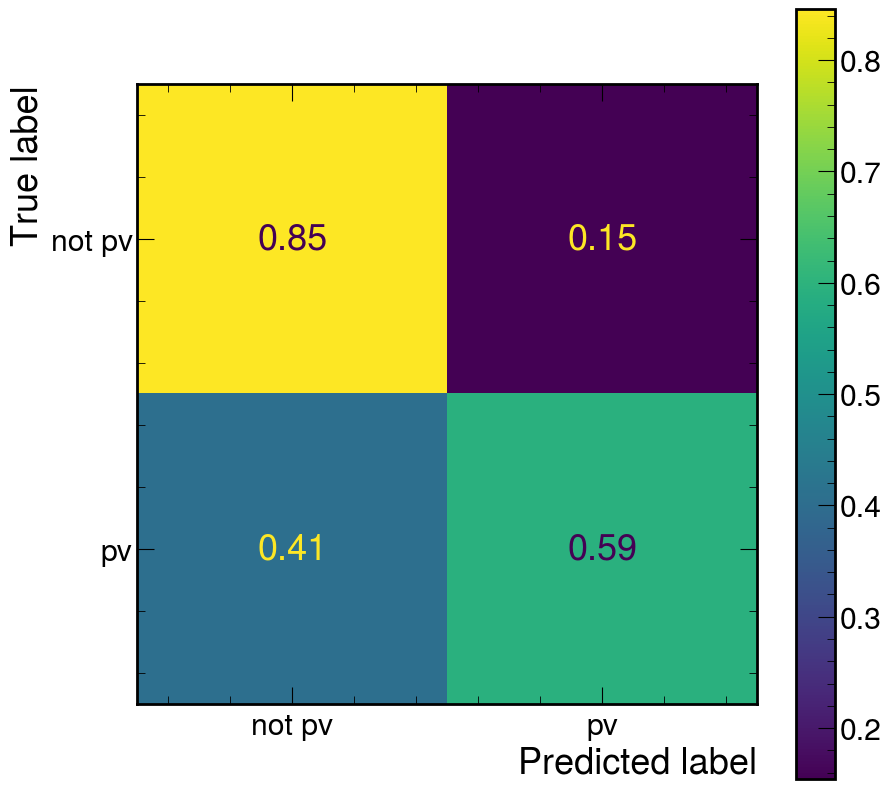

In [132]:
disp.plot()
plt.show()

Text(0, 1, 'True Positive Rate')

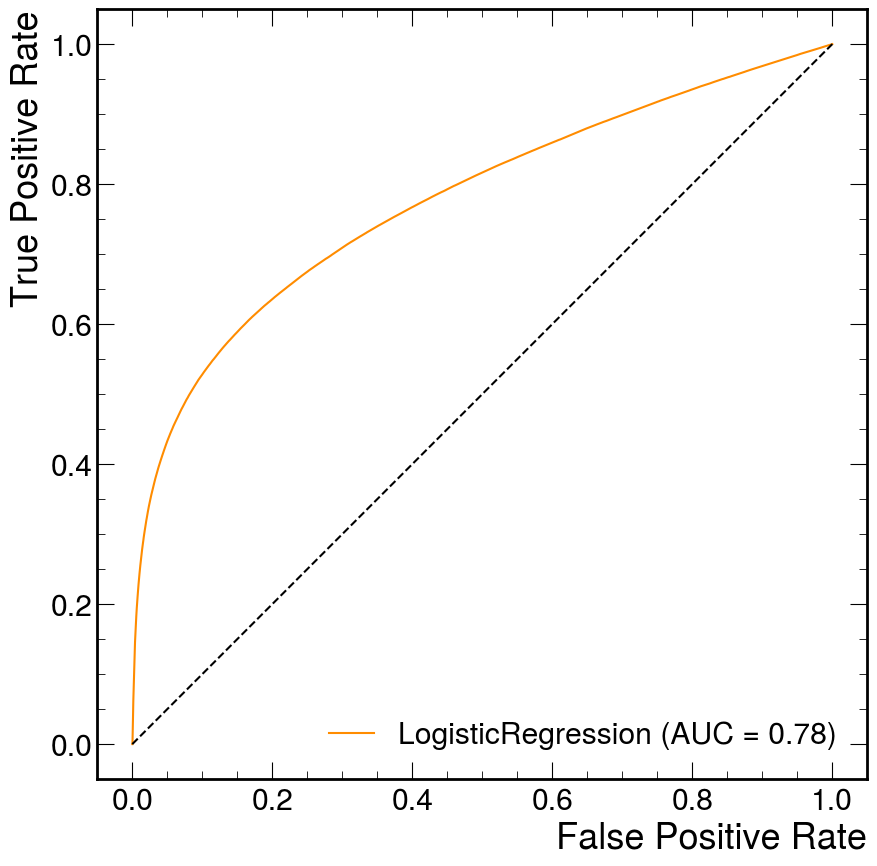

In [140]:
RocCurveDisplay.from_estimator(
    clf, val_df["trk_pt"].values.reshape(-1, 1), val_df["is_pv"], color="darkorange"
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## TRK z0 precision

In [225]:
def calc_eff(df, truth, pred_label: str = "y_pred") -> float:

    pred_z0 = df.groupby(["event_number", pred_label])["trk_z0"].median().reset_index()
    pred_z0 = pred_z0.loc[pred_z0[pred_label] == 1].copy()

    diff = np.abs(pred_z0["trk_z0"].values - truth["pv_MC"].values)

    mask = diff <= 0.15
    passed = np.sum(mask)
    eff = 100 * passed / pred_z0.shape[0]
    return eff

In [234]:
calc_eff(val_df, val_mc, "y_pred2")

39.78

In [231]:
val_pred_z0 = (
    val_df.groupby(["event_number", "y_pred"])["trk_z0"].median().reset_index()
)

In [232]:
val_pred_z0 = val_pred_z0.loc[val_pred_z0.y_pred == 1].copy()

In [206]:
val_pred_z0

,event_number,y_pred,trk_z0
1,15000,1,3.339844
3,15001,1,-3.691406
5,15002,1,1.875000
7,15003,1,2.197266
9,15004,1,-2.460938
...,...,...,...
19991,24995,1,-0.234375
19993,24996,1,-1.728516
19995,24997,1,7.236328
19997,24998,1,-2.871094


In [200]:
np.sum(
    np.abs(val_pred_z0["trk_z0"].values - val_mc["pv_MC"].values) < 0.15
) / val_mc.shape[0]

0.4002

In [201]:
val_mc

,event_number,pv_L1reco_z0,pv_L1reco_sum,pv_MC
15000,15000,3.376135,151.325394,3.332945
15001,15001,-5.163623,155.084427,-5.238919
15002,15002,2.099927,183.301041,1.923602
15003,15003,2.379128,264.830902,2.772585
15004,15004,-2.385478,479.106476,-2.482292
...,...,...,...,...
24995,24995,-0.085255,96.097534,-0.142578
24996,24996,-1.918857,204.352753,-1.878616
24997,24997,8.179408,304.295990,8.174589
24998,24998,-4.635422,168.583572,-4.748836


## Adding trk_eta info

In [156]:
clf2 = LogisticRegression(random_state=0).fit(
    train_df[["trk_pt", "trk_eta"]].values, y_train, sample_weight=weights_train
)

In [157]:
clf2

LogisticRegression(random_state=0)

In [192]:
clf2.intercept_

array([-1.38449621])

In [158]:
train_df["y_pred2"] = clf2.predict(train_df[["trk_pt", "trk_eta"]].values)
test_df["y_pred2"] = clf2.predict(test_df[["trk_pt", "trk_eta"]].values)
val_df["y_pred2"] = clf2.predict(val_df[["trk_pt", "trk_eta"]].values)

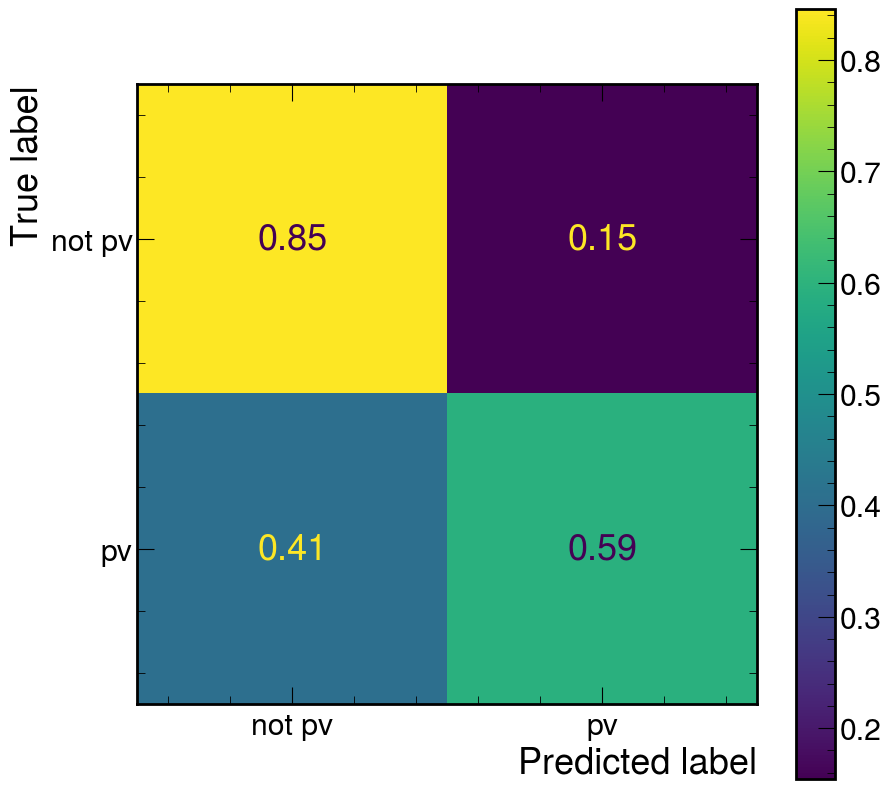

In [159]:
cm = confusion_matrix(val_df["is_pv"], val_df["y_pred2"], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not pv", "pv"])
disp.plot()
plt.show()

Text(0, 1, 'True Positive Rate')

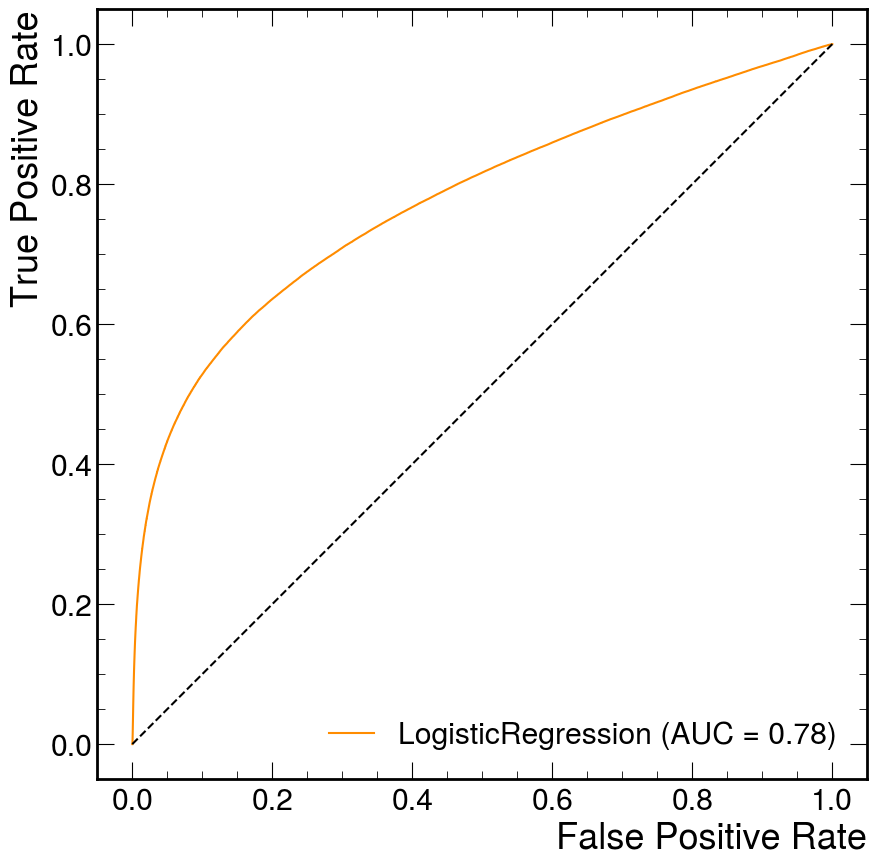

In [160]:
RocCurveDisplay.from_estimator(
    clf2, val_df[["trk_pt", "trk_eta"]].values, val_df["is_pv"], color="darkorange"
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## Trying a Decision Tree

In [189]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [162]:
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt = clf_dt.fit(
    train_df[["trk_pt", "trk_eta"]].values,
    train_df["is_pv"].values,
    sample_weight=train_df["weight"],
)

In [163]:
train_df["y_pred_dt"] = clf_dt.predict(train_df[["trk_pt", "trk_eta"]].values)
test_df["y_pred_dt"] = clf_dt.predict(test_df[["trk_pt", "trk_eta"]].values)
val_df["y_pred_dt"] = clf_dt.predict(val_df[["trk_pt", "trk_eta"]].values)

In [166]:
train_df["y_pred_dt"]

10265    0
2460     0
9221     0
13985    0
5411     0
        ..
6789     0
4410     0
1790     0
157      0
4636     1
Name: y_pred_dt, Length: 7500, dtype: int64

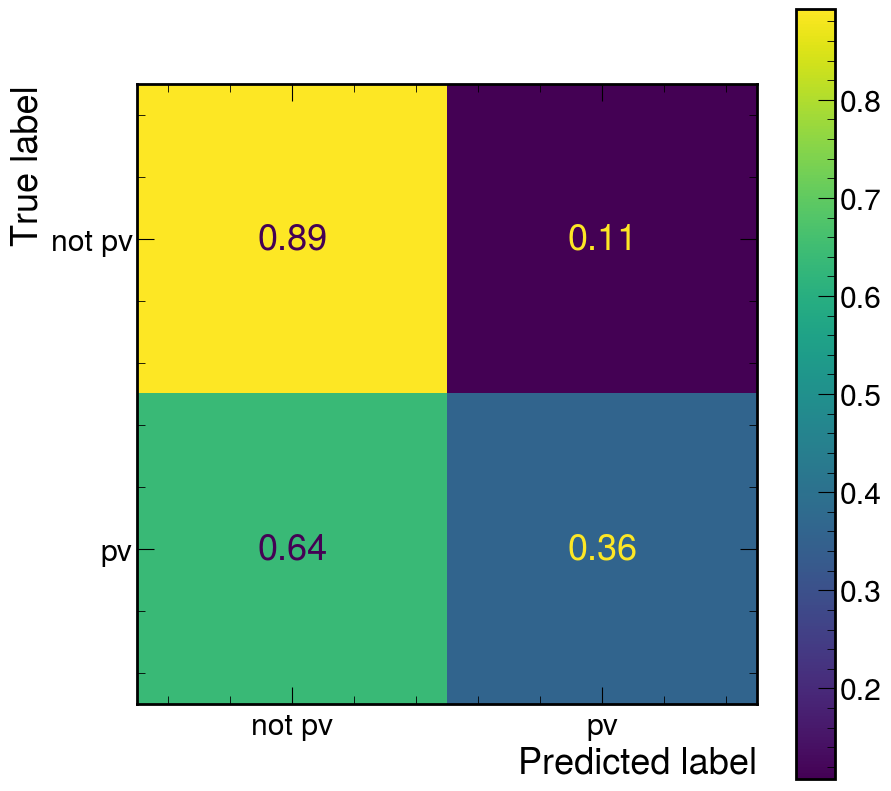

In [164]:
cm = confusion_matrix(val_df["is_pv"], val_df["y_pred_dt"], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not pv", "pv"])
disp.plot()
plt.show()

Text(0, 1, 'True Positive Rate')

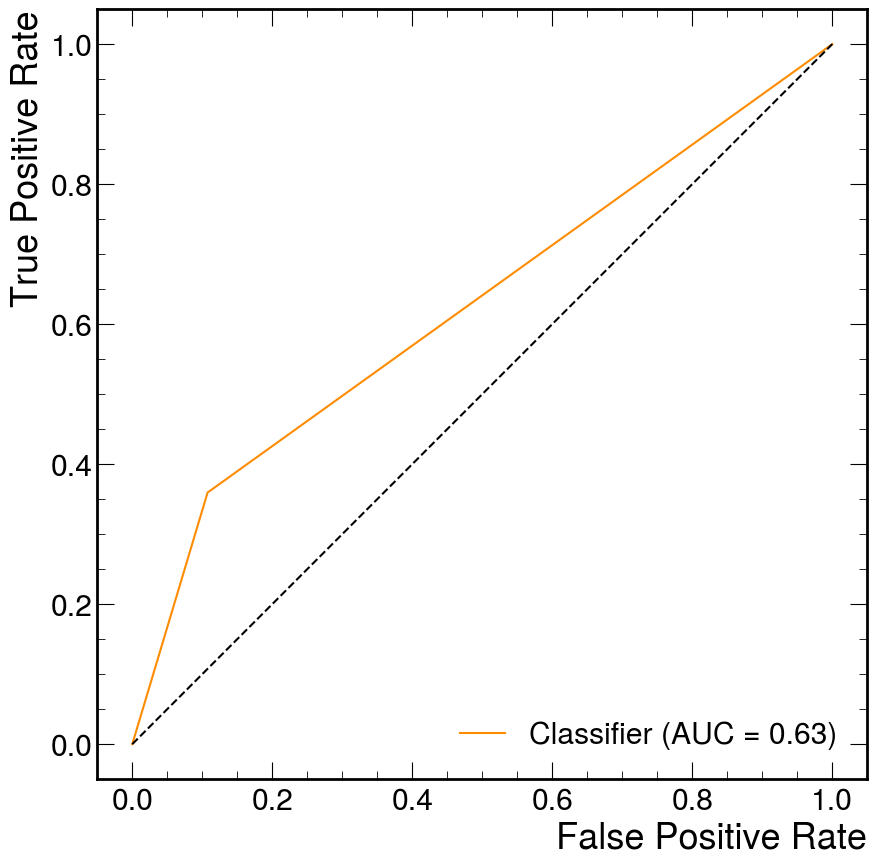

In [170]:
RocCurveDisplay.from_predictions(
    val_df["is_pv"],
    clf_dt.predict_proba(val_df[["trk_pt", "trk_eta"]].values)[:, 1],
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [190]:
plot_tree(clf_dt)

[Text(0.6298532979464962, 0.9875, 'X[0] <= 4.111\ngini = 0.497\nsamples = 7500\nvalue = [6390.0, 7500.0]'),
 Text(0.3987776303703075, 0.9625, 'X[0] <= 2.936\ngini = 0.472\nsamples = 6355\nvalue = [5823.0, 3594.595]'),
 Text(0.2461347574235153, 0.9375, 'X[0] <= 2.205\ngini = 0.432\nsamples = 4894\nvalue = [4581.0, 2114.865]'),
 Text(0.08653610046905093, 0.9125, 'X[0] <= 2.188\ngini = 0.377\nsamples = 2042\nvalue = [1945.0, 655.405]'),
 Text(0.07789255265723172, 0.8875, 'X[0] <= 2.183\ngini = 0.387\nsamples = 1917\nvalue = [1821.0, 648.649]'),
 Text(0.06919321316657721, 0.8625, 'X[1] <= 2.114\ngini = 0.38\nsamples = 1890\nvalue = [1799.0, 614.865]'),
 Text(0.06038229031825214, 0.8375, 'X[1] <= 2.105\ngini = 0.389\nsamples = 1763\nvalue = [1674.0, 601.351]'),
 Text(0.059371966067312855, 0.8125, 'X[0] <= 2.169\ngini = 0.387\nsamples = 1762\nvalue = [1674.0, 594.595]'),
 Text(0.04579141737441985, 0.7875, 'X[0] <= 2.168\ngini = 0.394\nsamples = 1675\nvalue = [1588.0, 587.838]'),
 Text(0.0236

Error in callback <function flush_figures at 0x7fb1c0408040> (for post_execute):


KeyboardInterrupt: 

## Trying XGBOOST

In [173]:
from xgboost import XGBClassifier

In [241]:
xgb = XGBClassifier(seed=20, scale_pos_weight=wp)

In [248]:
xgb.fit(train_df[["trk_pt", "trk_eta"]], train_df["is_pv"], verbose=3)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=20, ...)

In [249]:
train_df["y_pred_xgb"] = xgb.predict(train_df[["trk_pt", "trk_eta"]].values)
test_df["y_pred_xgb"] = xgb.predict(test_df[["trk_pt", "trk_eta"]].values)
val_df["y_pred_xgb"] = xgb.predict(val_df[["trk_pt", "trk_eta"]].values)

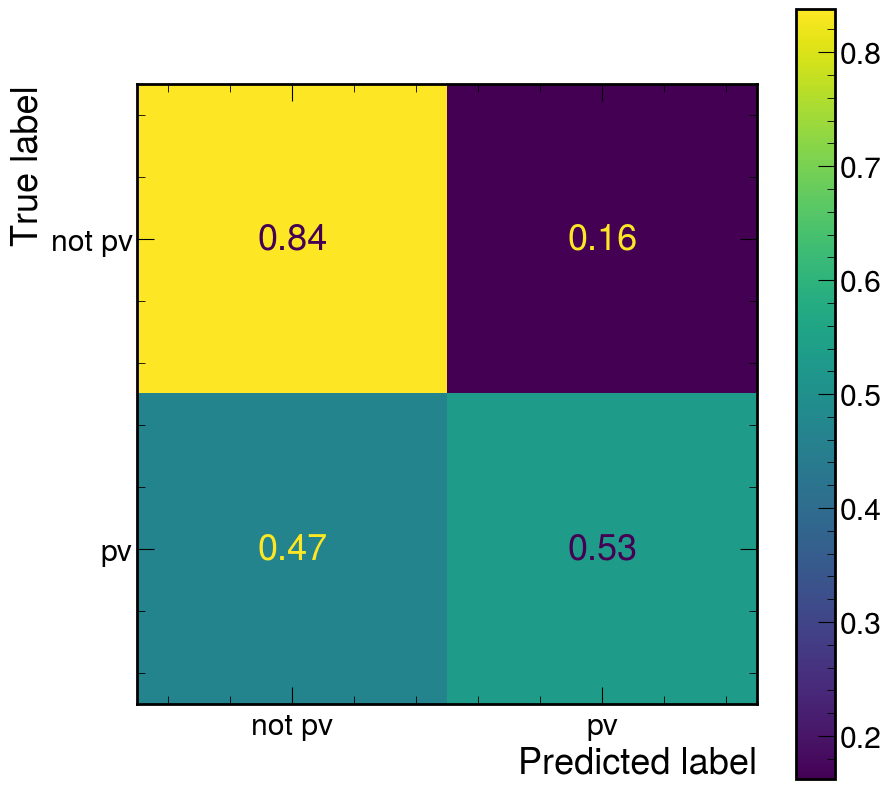

In [250]:
cm = confusion_matrix(val_df["is_pv"], val_df["y_pred_xgb"], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not pv", "pv"])
disp.plot()
plt.show()

Text(0, 1, 'True Positive Rate')

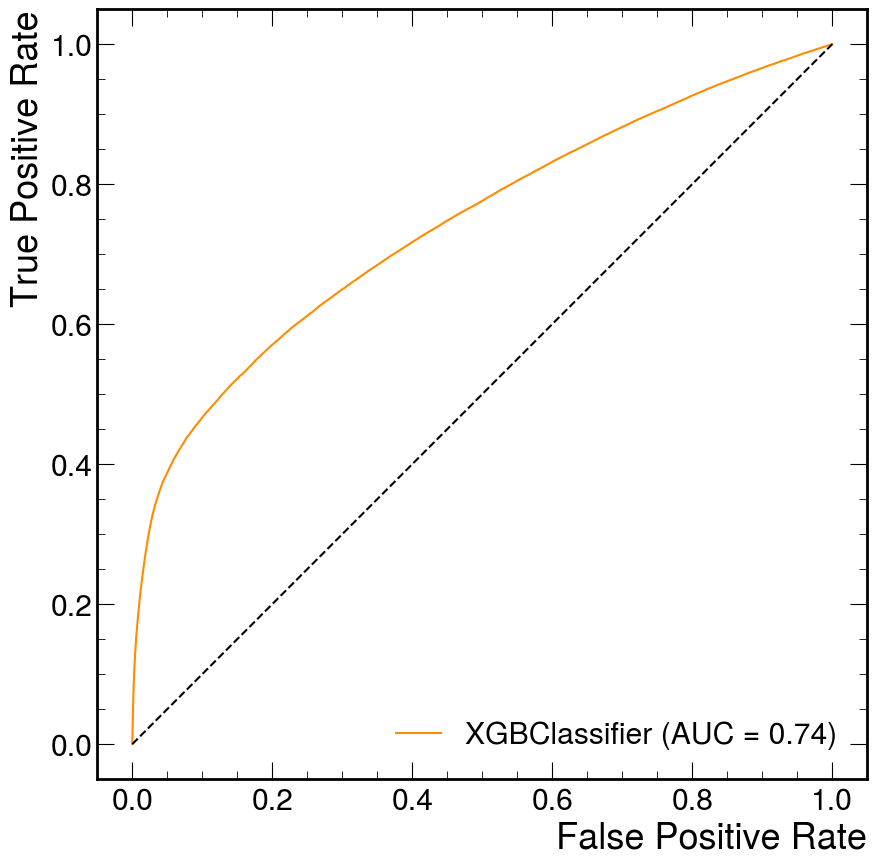

In [252]:
RocCurveDisplay.from_estimator(
    xgb,
    val_df[["trk_pt", "trk_eta"]].values,
    val_df["is_pv"],
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## Calculating Efficiencies for all the classifiers

In [253]:
print("Logistic regression Efficiency")
calc_eff(val_df, val_mc, "y_pred")

Logistic regression Efficiency


40.02

In [254]:
print("Logistic regression with $\eta$ efficiency")
calc_eff(val_df, val_mc, "y_pred2")

Logistic regression with $\eta$ efficiency


39.78

In [255]:
print("Decision Tree Efficiency")
calc_eff(val_df, val_mc, "y_pred_dt")

Decision Tree Efficiency


36.48

In [256]:
print("XGB Efficiency")
calc_eff(val_df, val_mc, "y_pred_xgb")

XGB Efficiency


35.94

clearly, to use this for a $z0$ determination is not good enough. Theres likely several reasons for tha

In [1]:
clf.coef_

NameError: name 'clf' is not defined